In [4]:
!cd drive/MyDrive/nla/

/content/drive/MyDrive/nla


In [5]:
!ls

ml-latest-small  nla.ipynb


In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163339 sha256=92668bf362a3f1feb05044c588a6ac0b0ed4557b44d7e223867f28fce8bf8a19
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [6]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from collections import defaultdict

from scipy.sparse.linalg import svds

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error

In [8]:
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=.25)

In [9]:
#Our dataset
movies = pd.read_csv('ml-latest-small/movies.csv', header=0)
ratings = pd.read_csv('ml-latest-small/ratings.csv', header=0)[['userId', 'movieId', 'rating']]
ratings.rating = ratings.rating.astype(np.int64)

In [10]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
ratings.head()

,userId,movieId,rating
0,1,1,4
1,1,3,4
2,1,6,4
3,1,47,5
4,1,50,5


In [12]:
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 610 | Number of movies = 9724


# SVD

## без малоранговой аппроксимации

In [14]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
R = Ratings.to_numpy()
user_ratings_mean = np.mean(R, axis = 1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

Ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
U, sigma, Vt = svds(Ratings_demeaned, k = 50)
sigma = np.diag(sigma)

In [16]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.634320,0.455143,0.803088,-0.110012,-0.663236,2.650509,-1.144025,-0.094488,0.231939,1.708948,...,-0.022922,-0.022922,-0.031836,-0.031836,-0.022922,-0.031836,-0.022922,-0.022922,-0.022922,-0.037620
1,0.186752,0.018741,0.035096,0.021592,0.184445,-0.050794,0.092270,0.030338,0.045273,-0.133832,...,0.015642,0.015642,0.020815,0.020815,0.015642,0.020815,0.015642,0.015642,0.015642,0.031870
2,0.002371,0.014057,0.034321,0.004766,-0.009831,0.117224,-0.035816,0.002051,0.003921,-0.023804,...,0.006666,0.006666,0.006155,0.006155,0.006666,0.006155,0.006666,0.006666,0.006666,0.009175
3,2.042142,-0.398217,-0.339900,0.088362,-0.001670,-0.010133,0.482346,0.012123,-0.028051,0.007894,...,-0.005957,-0.005957,-0.006308,-0.006308,-0.005957,-0.006308,-0.005957,-0.005957,-0.005957,-0.017678
4,1.339398,0.765276,0.008674,0.118940,0.240506,0.587503,0.234148,0.126857,-0.112105,1.016705,...,-0.007269,-0.007269,-0.008757,-0.008757,-0.007269,-0.008757,-0.007269,-0.007269,-0.007269,-0.009084


In [22]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):

    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1

    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print( 'User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]) )
    print( 'Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations) )

    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [24]:
already_rated, recommendations = recommend_movies(predictions=preds, userID=1, movies=movies, \
                                              original_ratings=ratings, num_recommendations=20)
recommendations.head(20)

User 1 has already rated 232 movies.
Recommending highest 20 predicted ratings movies not already rated.


,movieId,title,genres
736,1036,Die Hard (1988),Action|Crime|Thriller
844,1221,"Godfather: Part II, The (1974)",Crime|Drama
1328,1968,"Breakfast Club, The (1985)",Comedy|Drama
974,1387,Jaws (1975),Action|Horror
874,1259,Stand by Me (1986),Adventure|Drama
615,858,"Godfather, The (1972)",Crime|Drama
1416,2080,Lady and the Tramp (1955),Animation|Children|Comedy|Romance
1927,2804,"Christmas Story, A (1983)",Children|Comedy
3132,4571,Bill & Ted's Excellent Adventure (1989),Adventure|Comedy|Sci-Fi
2007,2918,Ferris Bueller's Day Off (1986),Comedy


## с малоранговой аппроксимацией

In [158]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
R = Ratings.to_numpy()

In [159]:
#make test set
rated_indices = np.argwhere(R>0)
random.seed(42)
test_set = random.sample(list(rated_indices), 10000)

print("1st index is "+str(test_set[0])+" and its rating is "+str(R[test_set[0][0],test_set[0][1]]))

test_ratings = []
for i in range(len(test_set)):
    test_ratings.append(R[test_set[i][0],test_set[i][1]])
    R[test_set[i][0],test_set[i][1]]=0

print("1st index is "+str(test_set[0])+" and its rating is "+str(R[test_set[0][0],test_set[0][1]]))

1st index is [551 684] and its rating is 3.0
1st index is [551 684] and its rating is 0.0


In [160]:
len(test_set)

10000

In [161]:
# user_ratings_mean = np.mean(R, axis = 1)

user_ratings_mean = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').agg('mean', axis=1).to_numpy()
# user_ratings_mean = np.zeros_like(user_ratings_mean)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [162]:
# print('Rank of the matrix:', np.linalg.matrix_rank(Ratings_demeaned))
# U, S, V = np.linalg.svd(Ratings_demeaned, full_matrices=False)
# threshold = 0.95
# S2i = S@S
# f = len(S)
# criteria=1
# while criteria >= threshold:
#     criteria = S[:f]@S[:f]/S2i
#     print(criteria)
#     f-=1
# # if f < 20: f = 20
# print("The f number = ", f)

In [163]:
#Так же сразу отложим часть выборки для тестирования модели по принципу:
#для каждого пользователя отрежем последние 20% оценок.

# rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

# def train_test_split(X, ratio=0.2, user_col='userId', item_col='movieId',
#                      rating_col='rating', time_col='timestamp'):
#     # сортируем оценки по времени
#     X.sort_values(by=[time_col], inplace=True)
#     # список всех юзеров
#     userIds = X[user_col].unique()
#     X_train_data = []
#     X_test_data = []
#     y_train = []
#     y_test = []
#     for userId in tqdm_notebook(userIds):
#         curUser = X[X[user_col] == userId]
#         # определяем позицию, по которой делим выборку и размещаем данные по массивам
#         idx = int(curUser.shape[0] * (1 - ratio))
#         X_train_data.append(curUser[[user_col, item_col]].iloc[:idx, :].values)
#         X_test_data.append(curUser[[user_col, item_col]].iloc[idx:, :].values)
#         y_train.append(curUser[rating_col].values[:idx])
#         y_test.append(curUser[rating_col].values[idx:])
#     # cтекуем данные по каждому пользователю в общие массивы
#     X_train = pd.DataFrame(np.vstack(X_train_data), columns=[user_col, item_col])
#     X_test = pd.DataFrame(np.vstack(X_test_data), columns=[user_col, item_col])
#     y_train = np.hstack(y_train)
#     y_test = np.hstack(y_test)
#     return X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = train_test_split(ratings)
# X_train.shape, len(y_train), X_test.shape, len(y_test)

In [168]:
def printRMSEGraph(kArr, RMSEArr):
    plt.plot(kArr, RMSEArr)
    plt.title('Зависимость качества от ранга')
    plt.xlabel("Rank")
    plt.ylabel("RMSE")

def svdPrediction(kArr):
    rmses = []
    for k in kArr:
        if k is None:
            U, sigma, Vt = svds(Ratings_demeaned)
        else:
            U, sigma, Vt = svds(Ratings_demeaned, k = k)
        sigma = np.diag(sigma)
        predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
        preds_df = pd.DataFrame(predicted_ratings, columns = Ratings.columns)
        pred_set = [predicted_ratings[x[0],x[1]] for x in test_set]

        res_df = pd.DataFrame()
        res_df["act"] = test_ratings
        res_df["pred"] = pred_set

        rmse = np.sqrt(mean_squared_error(res_df["act"].values, res_df["pred"].values))
        rmses.append(rmse)
        print(f"k: {k}; RMSE: {rmse}")
    return rmses

k: 1; RMSE: 3.1475400469516113
k: 2; RMSE: 2.954866524284891
k: 4; RMSE: 2.8185342111453493
k: 8; RMSE: 2.7834296945480554
k: 16; RMSE: 2.810610529239695
k: 32; RMSE: 2.902475391742696
k: 64; RMSE: 3.05926274393837
k: 128; RMSE: 3.2796940626103432
k: 256; RMSE: 3.452801455653247
k: 512; RMSE: 3.53321070935093
k: 555; RMSE: 3.536996450743667
k: 609; RMSE: 3.539654390342925


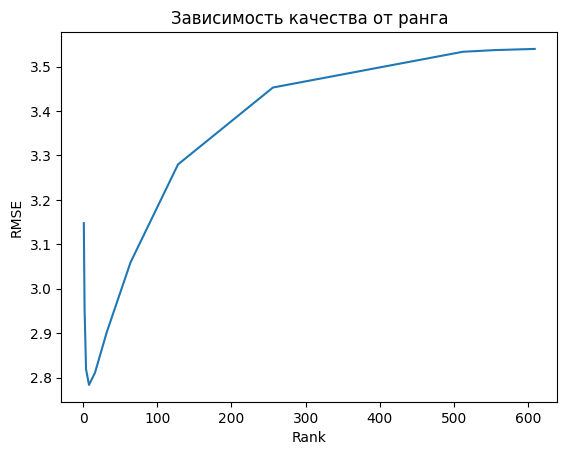

In [170]:
kArr = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 555, 609]
rmses = svdPrediction(kArr)
printRMSEGraph(kArr, rmses)

In [ ]:
kArr = [None]
rmses = svdPrediction(kArr)
# printRMSEGraph(kArr, rmses)

k: 4; RMSE: 2.827674859451978
k: 6; RMSE: 2.790741709207751
k: 8; RMSE: 2.7861194413958574
k: 10; RMSE: 2.789770006668382
k: 12; RMSE: 2.7998860820206715
k: 14; RMSE: 2.8065853694136194


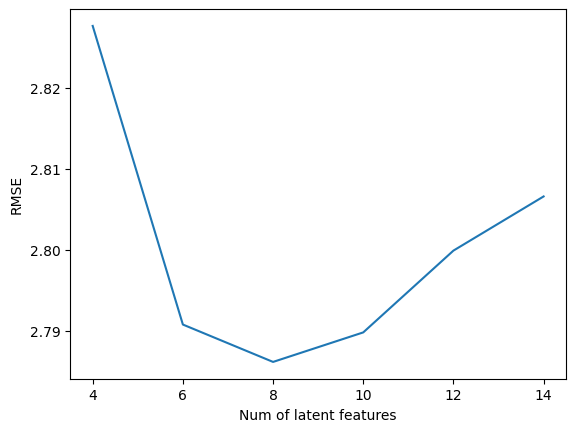

In [131]:
kArr_2 = [4, 6, 8, 10, 12, 14]
rmses = svdPrediction(kArr_2)
printRMSEGraph(kArr_2, rmses)

best k = 8 with RMSE: 2.78

# через mean

In [132]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating')
R = Ratings.fillna(0).to_numpy()

Ratings_mean = Ratings.fillna(Ratings.agg('mean', axis=0))
Ratings_mean.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.000000,3.281818,4.000000,2.285714,3.0,4.000000,3.12963,2.875,3.0625,3.386364,...,3.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0,4.0
2,3.813953,3.281818,3.173077,2.285714,3.0,3.872549,3.12963,2.875,3.0625,3.386364,...,3.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0,4.0
3,3.813953,3.281818,3.173077,2.285714,3.0,3.872549,3.12963,2.875,3.0625,3.386364,...,3.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0,4.0
4,3.813953,3.281818,3.173077,2.285714,3.0,3.872549,3.12963,2.875,3.0625,3.386364,...,3.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0,4.0
5,4.000000,3.281818,3.173077,2.285714,3.0,3.872549,3.12963,2.875,3.0625,3.386364,...,3.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0,4.0


In [144]:
user_ratings_mean = Ratings.agg('mean', axis=1).to_numpy()
# user_ratings_mean = np.zeros_like(user_ratings_mean)
Ratings_demeaned = Ratings_mean.to_numpy() - user_ratings_mean.reshape(-1, 1)

In [145]:
#make test set
rated_indices = np.argwhere(R>0)
random.seed(42)
test_set = random.sample(list(rated_indices), 10000)

print("1st index is "+str(test_set[0])+" and its rating is "+str(R[test_set[0][0],test_set[0][1]]))

test_ratings = []
for i in range(len(test_set)):
    test_ratings.append(R[test_set[i][0],test_set[i][1]])
    Ratings_demeaned[test_set[i][0],test_set[i][1]] = 0

print("1st index is "+str(test_set[0])+" and its rating is "+str(Ratings_demeaned[test_set[0][0],test_set[0][1]]))

1st index is [551 684] and its rating is 3.0
1st index is [551 684] and its rating is 0.0


In [146]:
# user_ratings_mean = np.mean(R, axis = 1)
# Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

k: 1; RMSE: 0.8524271146477028
k: 2; RMSE: 0.8559496871195286
k: 3; RMSE: 0.8482362384570604
k: 4; RMSE: 0.844284417434981
k: 8; RMSE: 0.840807396980058
k: 16; RMSE: 0.8499624674815675
k: 32; RMSE: 0.8587763326280661
k: 64; RMSE: 0.8733437316498774
k: 128; RMSE: 0.8867185802113444
k: 256; RMSE: 0.9026289582272976
k: 512; RMSE: 0.9137188455281812


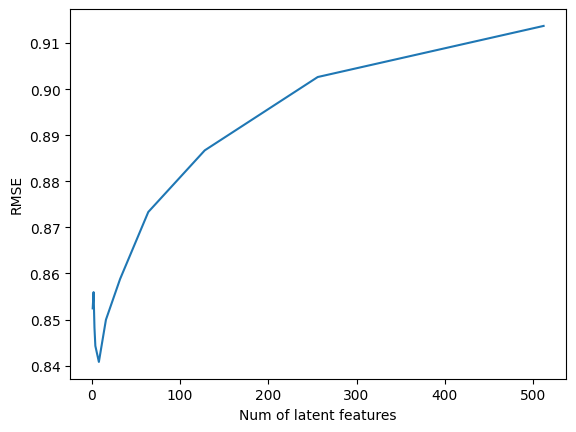

In [147]:
kArr = [1, 2, 3, 4, 8, 16, 32, 64, 128, 256, 512]
rmses = svdPrediction(kArr)
printRMSEGraph(kArr, rmses)

In [138]:
kArr = [None]
rmses = svdPrediction(kArr)

k: None; RMSE: 0.8390648058054053


k: 4; RMSE: 0.8442844174349803
k: 6; RMSE: 0.839064805805405
k: 8; RMSE: 0.8408073969800577
k: 10; RMSE: 0.842757076141886
k: 12; RMSE: 0.8463857800229171
k: 14; RMSE: 0.8475327448637192


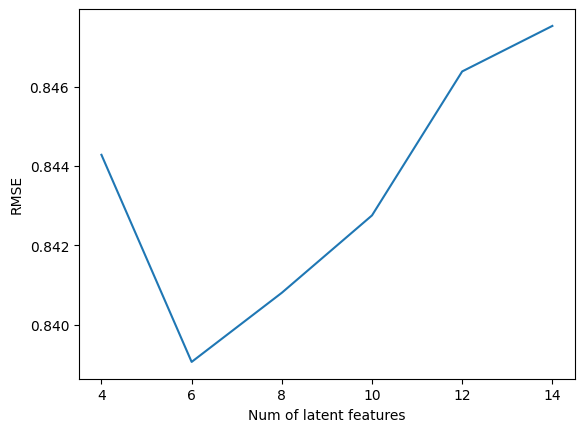

In [139]:
kArr_2 = [4, 6, 8, 10, 12, 14]
rmses = svdPrediction(kArr_2)
printRMSEGraph(kArr_2, rmses)

best k = 6 with RMSE: 0.84

# SVD + optimization

In [70]:
#слишком не оптимально
def SVD(R, d, step, lambda_reg, n_iters):
    # инициализуем наши матрицы для разложения
    U = np.zeros((R.shape[0], d))
    V = np.zeros((d, R.shape[1]))
    # начальные элементы матрица U и V будут средним рейтингом по ненулевым оценкам
    mu = R.sum() / (R != 0).sum()
    non_zero = (R != 0).sum()
    U = U + mu
    V = V + mu
    # Создадим списки, где будут индексы нулевых и ненулевых элементов матрицы R
    indx = []
    zero_indx = []
    # Инициализируем MSE в начале и будем отслеживать в процессе обучения
    MSE_start = 0
    MSE = []
    # Найдём индексы нулевых и ненулевых элементов
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if R[i][j] > 0:
                indx.append([i, j])
                MSE_start += ((R[i, j] - np.dot(U[i, :], V[:, j])) ** 2) / non_zero
            else:
                zero_indx.append([i, j])
    # Сделаем градиентный спуск
    for n in range(n_iters):
        choice = np.random.randint(0, len(indx))
        ij = indx[choice]
        for k in range(0, d):
            U[ij[0], k] = U[ij[0], k] + step * (
                (R[ij[0]][ij[1]] - np.dot(U[ij[0], :], V[:, ij[1]])) * V[k, ij[1]]
                - lambda_reg * U[ij[0], k]
            )
            V[k, ij[1]] = V[k, ij[1]] + step * (
                (R[ij[0]][ij[1]] - np.dot(U[ij[0], :], V[:, ij[1]])) * U[ij[0], k]
                - lambda_reg * V[k, ij[1]]
            )

        L = 0
        for i in range(R.shape[0]):
            for j in range(R.shape[1]):
                if R[i, j] > 0:
                    L += ((R[i, j] - np.dot(U[i, :], V[:, j])) ** 2) / non_zero
        MSE.append(L)
    return U, V, MSE_start, MSE

In [ ]:
A, B, M_1, M_end = SVD(R, 2, 0.01, 0.1, 3000)

## Singular value thresholding algorithm

In [181]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)

R = Ratings.to_numpy()
user_ratings_mean = np.mean(R, axis = 1)
user_ratings_mean = np.zeros_like(user_ratings_mean)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [186]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating')
R = Ratings.fillna(0).to_numpy()

Ratings_mean = Ratings.fillna(Ratings.agg('mean', axis=0))

user_ratings_mean = Ratings.agg('mean', axis=1).to_numpy()
# user_ratings_mean = np.zeros_like(user_ratings_mean)
Ratings_demeaned = Ratings_mean.to_numpy() - user_ratings_mean.reshape(-1, 1)

In [187]:
#test data
rated_indices = np.argwhere(R>0)
random.seed(123)
test_set = random.sample(list(rated_indices), 10000)

print("1st index is "+str(test_set[0])+" and its rating is "+str(R[test_set[0][0],test_set[0][1]]))

test_ratings = []
for i in range(len(test_set)):
    test_ratings.append(R[test_set[i][0],test_set[i][1]])
    Ratings_demeaned[test_set[i][0],test_set[i][1]]=0

print("1st index is "+str(test_set[0])+" and its rating is "+str(Ratings_demeaned[test_set[0][0],test_set[0][1]]))

1st index is [  46 4007] and its rating is 4.0
1st index is [  46 4007] and its rating is 0.0


In [188]:
def svtPredictionWithCap(tau, delta, epsilon, max_iterations):
    Y = np.zeros_like(Ratings_demeaned)
    mask = np.round(R > 0).astype(int)
    print("==========================================================")
    print(f"Parameters: tau = {tau}, delta = {delta}")

    for i in range(max_iterations):
        U, S, V = svds(Y, k=50)
        S = np.maximum(S - tau, 0)
        X = np.linalg.multi_dot([U, np.diag(S), V])
        Y = Y + delta * mask * (Ratings_demeaned - X)

        error = np.linalg.norm(mask * (X - Ratings_demeaned)) / np.linalg.norm(mask * Ratings_demeaned)
        print(f"Iteration number: {i + 1}; Relative error: {error}")

        if error < epsilon:
            break

    pred_set = [X[x[0],x[1]] for x in test_set]

    res_df = pd.DataFrame()
    res_df["act"] = test_ratings
    res_df["pred"] = pred_set
    res_df["pred"] = np.where(res_df["pred"] > 5, 5, res_df["pred"])
    res_df["pred"] = np.where(res_df["pred"] < 0, 0, res_df["pred"])


    differences = abs(res_df["act"] - res_df["pred"])
    print(f"The smallest prediction diffrence is {differences.min()} and the biggest is {differences.max()}")

    rmse = np.sqrt(mean_squared_error(res_df["act"].values, res_df["pred"].values))
    print(f"RMSE: {rmse}")
    return rmse

In [189]:
taus = [0.5, 1, 1.5, 2]
deltas = [0.5, 1, 1.5, 2]
results = pd.DataFrame(columns=["delta", "tau", "rmse"])
bestResult = [0.0, 0.0, float("inf")]

for delta in deltas:
    for tau in taus:
        rmse= svtPredictionWithCap(tau, delta, 0.01, 5)
        if rmse < bestResult[2]:
            bestResult = [delta, tau, rmse]
        results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))

Parameters: tau = 0.5, delta = 0.5
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.7894785452184913
Iteration number: 3; Relative error: 0.688875715064326
Iteration number: 4; Relative error: 0.6371281461880002
Iteration number: 5; Relative error: 0.6139939837625019
The smallest prediction diffrence is 0.036315684130521886 and the biggest is 5.0
RMSE: 3.4828603183905162


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 1, delta = 0.5
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.7959562305437906
Iteration number: 3; Relative error: 0.6921352939452315
Iteration number: 4; Relative error: 0.6386891514377107
Iteration number: 5; Relative error: 0.613270413842043
The smallest prediction diffrence is 0.19842142542559227 and the biggest is 5.0
RMSE: 3.4828883839876803


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 1.5, delta = 0.5
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.802549960363872
Iteration number: 3; Relative error: 0.6953339598496163
Iteration number: 4; Relative error: 0.6401169515005208
Iteration number: 5; Relative error: 0.6133060517100984
The smallest prediction diffrence is 0.45331940233471146 and the biggest is 5.0
RMSE: 3.483654300566878


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 2, delta = 0.5
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.8092568981331101
Iteration number: 3; Relative error: 0.6986748329170035
Iteration number: 4; Relative error: 0.6415784514784065
Iteration number: 5; Relative error: 0.6127104443291165
The smallest prediction diffrence is 0.44024798015186917 and the biggest is 5.0
RMSE: 3.484320489227619


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 0.5, delta = 1
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.6681660734875612
Iteration number: 3; Relative error: 0.6562335490671246
Iteration number: 4; Relative error: 0.7433884940588313
Iteration number: 5; Relative error: 0.7501064310920139
The smallest prediction diffrence is 0.008239849970958169 and the biggest is 5.0
RMSE: 3.4457677981137245


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 1, delta = 1
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.6703088151208134
Iteration number: 3; Relative error: 0.6518588776490588
Iteration number: 4; Relative error: 0.7354600107293547
Iteration number: 5; Relative error: 0.7490554848880953
The smallest prediction diffrence is 0.04435597518432832 and the biggest is 5.0
RMSE: 3.4458643665647055


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 1.5, delta = 1
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.6726455856206527
Iteration number: 3; Relative error: 0.6476214662925412
Iteration number: 4; Relative error: 0.7272003946177212
Iteration number: 5; Relative error: 0.7450069954780484
The smallest prediction diffrence is 0.12291868378674908 and the biggest is 5.0
RMSE: 3.4454050672581626


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 2, delta = 1
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.6751743703952566
Iteration number: 3; Relative error: 0.643046831415589
Iteration number: 4; Relative error: 0.7172520922294665
Iteration number: 5; Relative error: 0.7416907921508068
The smallest prediction diffrence is 0.010231130242574826 and the biggest is 5.0
RMSE: 3.444746536861668


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 0.5, delta = 1.5
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.697789584426782
Iteration number: 3; Relative error: 0.8608590429627981
Iteration number: 4; Relative error: 1.0173934015853443
Iteration number: 5; Relative error: 0.9571077577196905
The smallest prediction diffrence is 0.015434811365812262 and the biggest is 5.0
RMSE: 3.431358740507561


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 1, delta = 1.5
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.6945332017197559
Iteration number: 3; Relative error: 0.8542802643284568
Iteration number: 4; Relative error: 1.018442290116387
Iteration number: 5; Relative error: 0.953406343420298
The smallest prediction diffrence is 0.005674713698033296 and the biggest is 5.0
RMSE: 3.430694180470461


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 1.5, delta = 1.5
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.6914568698082961
Iteration number: 3; Relative error: 0.8475050065944447
Iteration number: 4; Relative error: 1.0186852237336816
Iteration number: 5; Relative error: 0.9485263053171503
The smallest prediction diffrence is 0.002841670298406762 and the biggest is 5.0
RMSE: 3.4301741570483526


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 2, delta = 1.5
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.6885630019660344
Iteration number: 3; Relative error: 0.8409976779720977
Iteration number: 4; Relative error: 1.0191515827661521
Iteration number: 5; Relative error: 0.9446035403862807
The smallest prediction diffrence is 0.0008463101577145249 and the biggest is 5.0
RMSE: 3.430227268038578


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 0.5, delta = 2
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.8629423969677557
Iteration number: 3; Relative error: 1.0504484238347622
Iteration number: 4; Relative error: 0.973085736933358
Iteration number: 5; Relative error: 1.1263514735252962
The smallest prediction diffrence is 0.007384874314554368 and the biggest is 5.0
RMSE: 3.414463447352677


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 1, delta = 2
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.8559986582517285
Iteration number: 3; Relative error: 1.0439338723425842
Iteration number: 4; Relative error: 0.9728074858210657
Iteration number: 5; Relative error: 1.1098283778903222
The smallest prediction diffrence is 0.005870257952431346 and the biggest is 5.0
RMSE: 3.4149859167660974


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 1.5, delta = 2
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.8491572267433519
Iteration number: 3; Relative error: 1.037490946367008
Iteration number: 4; Relative error: 0.9736662859667666
Iteration number: 5; Relative error: 1.1040901394627944
The smallest prediction diffrence is 0.01077780034164122 and the biggest is 5.0
RMSE: 3.416525491671479


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


Parameters: tau = 2, delta = 2
Iteration number: 1; Relative error: 1.0
Iteration number: 2; Relative error: 0.842420595005583
Iteration number: 3; Relative error: 1.0311168561478246
Iteration number: 4; Relative error: 0.9758896734430144
Iteration number: 5; Relative error: 1.0978141435043
The smallest prediction diffrence is 0.005178195958692067 and the biggest is 5.0
RMSE: 3.4189181986008426


<ipython-input-189-5c254aafea7e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame([[delta, tau, rmse]], columns=["delta", "tau", "rmse"]))


In [190]:
print(f"Best result found for delta: {bestResult[0]} tau: {bestResult[1]} and the RMSE: {bestResult[2]}")

Best result found for delta: 2 tau: 0.5 and the RMSE: 3.414463447352677


#SVD + Optimization (или Probabilistic Matrix Factorization (PMF))

In [179]:
reader = Reader()

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

svd = SVD(biased=False)

train_data, test_data = train_test_split(data, test_size=0.1, train_size=None, random_state=42, shuffle=False)
svd.fit(train_data)
predictions = svd.test(test_data)
accuracy.rmse(predictions)

RMSE: 1.1195


1.1195142916181082

In [46]:
reader = Reader()

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

svd = SVD(biased=False)
rmse = cross_validate(svd, data, measures=['rmse'], cv=5)

print('RMSE = ', np.mean(rmse['test_rmse']))

RMSE =  1.0165374466829464


In [44]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [45]:
svd.predict(2, 1)

Prediction(uid=2, iid=1, r_ui=None, est=3.5787663514656334, details={'was_impossible': False})

In [17]:
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

In [18]:
accuracy.rmse(predictions)

RMSE: 0.9495


0.9494621139379719

In [21]:
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
    return top_n

In [24]:
top_n = get_top_n(predictions, n=10)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

72 ['98', '480', '187', '528', '97', '530', '197', '647', '520', '89']
296 ['14', '285', '187', '144', '242', '272', '56', '124', '315', '134']
58 ['8', '134', '32', '318', '168', '228', '195', '171', '204', '45']
291 ['427', '89', '655', '735', '246', '8', '28', '124', '172', '48']
363 ['169', '657', '603', '183', '518', '144', '346', '298', '154', '223']
299 ['318', '170', '98', '487', '511', '480', '166', '23', '478', '207']
557 ['127', '198', '8', '166', '298', '334', '322', '739', '875', '872']
808 ['302', '340', '271', '312', '294']
805 ['661', '527', '190', '98', '7', '13', '56', '183', '475', '168']
618 ['172', '496', '136', '204', '195', '132', '144', '684', '1', '66']
305 ['64', '59', '168', '127', '923', '479', '181', '86', '527', '199']
269 ['100', '93', '603', '127', '137', '197', '272', '762', '173', '529']
851 ['174', '272', '435', '258', '527', '223', '79', '132', '11', '160']
628 ['8', '173', '168', '333', '326']
846 ['483', '427', '519', '269', '177', '199', '268', '5